# 6 version of 2.5d Cutting model baseline [training]
#  author YOYOBAR
https://www.kaggle.com/code/yoyobar/2-5d-cutting-model-baseline-training

**This code is base on [2.5d segmentaion baseline [training]](https://www.kaggle.com/code/tanakar/2-5d-segmentaion-baseline-training)**
If you think my code is useful,please upvote it ^w^.
* Version6:
1. *     using kidney_1_dense for training and kidney_3_dense for val
2. *     image_size = 512
3. *     useing DiceLoss
4. *     norm_with_clip
5. *     fix some bug


* This version is correspond with [2.5d Cutting model baseline [inference]](https://www.kaggle.com/code/yoyobar/2-5d-cutting-model-baseline-inference) version3



According to my experiments, using kidney_1_dense for training and kidney_3_dense for val is the best. You can even get 0.757, but using 2d model(se_resnext50_32x4d), you can set CFG.in_chans=1 to make this notebook as a 2d model training notebook.'

# Import

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp /kaggle/input/se-net-pretrained-imagenet-weights/* /root/.cache/torch/hub/checkpoints/
import torch as tc 
import torch.nn as nn  
import numpy as np
from tqdm import tqdm
import os,sys,cv2
from torch.cuda.amp import autocast
import matplotlib.pyplot as plt
import albumentations as A
# !python -m pip install --no-index --find-links=/kaggle/input/pip-download-for-segmentation-models-pytorch segmentation-models-pytorch
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from glob import glob

# config

In [3]:
p_augm = 0.05 #0.5
#add rotate.  less p_augm

class CFG:
    # ============== pred target =============
    target_size = 1

    # ============== model CFG =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'

    in_chans = 1   #5 # 65
    # ============== training CFG =============
    image_size = 512
    input_size=512

    train_batch_size = 16
    valid_batch_size = train_batch_size * 2

    epochs = 25   #. 45 #30 #25
    lr = 6e-5
    chopping_percentile=1e-3
    # ============== fold =============
    valid_id = 1

    rotate_p = 0.02 #0.25 #0.5
    # ============== augmentation =============
    train_aug_list = [
        A.Rotate(limit=270, p= rotate_p),
        A.RandomScale(scale_limit=(0.8,1.25),interpolation=cv2.INTER_CUBIC,p=p_augm),
        A.RandomCrop(input_size, input_size,p=1),
        A.RandomGamma(p=p_augm*2/3),
        A.RandomBrightnessContrast(p=p_augm,),
        A.GaussianBlur(p=p_augm),
        A.MotionBlur(p=p_augm),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=p_augm),
        ToTensorV2(transpose_mask=True),
    ]
    train_aug = A.Compose(train_aug_list)
    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]
    valid_aug = A.Compose(valid_aug_list)

# Model

In [4]:
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.model = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.model(image)
        # output = output.squeeze(-1)
        return output[:,0]#.sigmoid()


def build_model(weight="imagenet"):
    from dotenv import load_dotenv
    load_dotenv()

    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight)

    return model.cuda()

# Functions

In [5]:
def min_max_normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,...)"""
    shape=x.shape
    if x.ndim>2:
        x=x.reshape(x.shape[0],-1)
    
    min_=x.min(dim=-1,keepdim=True)[0]
    max_=x.max(dim=-1,keepdim=True)[0]
    if min_.mean()==0 and max_.mean()==1:
        return x.reshape(shape)
    
    x=(x-min_)/(max_-min_+1e-9)
    return x.reshape(shape)

def norm_with_clip(x:tc.Tensor,smooth=1e-5):
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    x=(x-mean)/(std+smooth)
    x[x>5]=(x[x>5]-5)*1e-3 +5
    x[x<-3]=(x[x<-3]+3)*1e-3-3
    return x

def add_noise(x:tc.Tensor,max_randn_rate=0.1,randn_rate=None,x_already_normed=False):
    """input.shape=(batch,f1,f2,...) output's var will be normalizate  """
    ndim=x.ndim-1
    if x_already_normed:
        x_std=tc.ones([x.shape[0]]+[1]*ndim, device=x.device,dtype=x.dtype)
        x_mean=tc.zeros([x.shape[0]]+[1]*ndim, device=x.device,dtype=x.dtype)
    else: 
        dim=list(range(1,x.ndim))
        x_std=x.std(dim=dim,keepdim=True)
        x_mean=x.mean(dim=dim,keepdim=True)
    if randn_rate is None:
        randn_rate=max_randn_rate*np.random.rand()*tc.rand(x_mean.shape,device=x.device,dtype=x.dtype)
    cache=(x_std**2+(x_std*randn_rate)**2)**0.5
    #https://blog.csdn.net/chaosir1991/article/details/106960408
    
    return (x - x_mean + tc.randn(size=x.shape,device=x.device,dtype=x.dtype) * randn_rate * x_std) / (cache+1e-7)

class Data_loader(Dataset):
    def __init__(self,paths,is_label):
        self.paths=paths
        self.paths.sort()
        self.is_label=is_label
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        img=cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        img=tc.from_numpy(img)
        if self.is_label:
            img=(img!=0).to(tc.uint8)*255
        else:
            img=img.to(tc.uint8)
        return img

def load_data(paths,is_label=False):
    data_loader=Data_loader(paths,is_label)
    data_loader=DataLoader(data_loader, batch_size=16, num_workers=2)
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    x=tc.cat(data,dim=0)
    del data
    if not is_label:
        ########################################################################
        TH=x.reshape(-1).numpy()
        index = -int(len(TH) * CFG.chopping_percentile)
        TH:int = np.partition(TH, index)[index]
        x[x>TH]=int(TH)
        ########################################################################
        TH=x.reshape(-1).numpy()
        index = -int(len(TH) * CFG.chopping_percentile)
        TH:int = np.partition(TH, -index)[-index]
        x[x<TH]=int(TH)
        ########################################################################
        x=(min_max_normalization(x.to(tc.float16)[None])[0]*255).to(tc.uint8)
    return x


#https://www.kaggle.com/code/kashiwaba/sennet-hoa-train-unet-simple-baseline
def dice_coef(y_pred:tc.Tensor,y_true:tc.Tensor, thr=0.5, dim=(-1,-2), epsilon=0.001):
    y_pred=y_pred.sigmoid()
    y_true = y_true.to(tc.float32)
    y_pred = (y_pred>thr).to(tc.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean()
    return dice

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = inputs.sigmoid()   
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class Kaggld_Dataset(Dataset):
    def __init__(self,x:list,y:list,arg=False):
        super(Dataset,self).__init__()
        self.x=x#list[(C,H,W),...]
        self.y=y#list[(C,H,W),...]
        self.image_size=CFG.image_size
        self.in_chans=CFG.in_chans
        self.arg=arg
        if arg:
            self.transform=CFG.train_aug
        else: 
            self.transform=CFG.valid_aug

    def __len__(self) -> int:
        return sum([y.shape[0]-self.in_chans for y in self.y])
    
    def __getitem__(self,index):
        i=0
        for x in self.x:
            if index>x.shape[0]-self.in_chans:
                index-=x.shape[0]-self.in_chans
                i+=1
            else:
                break
        x=self.x[i]
        y=self.y[i]
        
        print (f'x.shape[1] ={x.shape[1]}    x.shape[2]={x.shape[2]}')
        
        x_index= (x.shape[1]-self.image_size)//2 #np.random.randint(0,x.shape[1]-self.image_size)
        y_index= (x.shape[2]-self.image_size)//2 # np.random.randint(0,x.shape[2]-self.image_size)
        # i i+5 
        x=x[index:index+self.in_chans   ,   x_index:x_index+self.image_size,   y_index:y_index+self.image_size]
        # i+2
        y=y[index+self.in_chans//2   ,      x_index:x_index+self.image_size,   y_index:y_index+self.image_size]

        data = self.transform(image=x.numpy().transpose(1,2,0), mask=y.numpy())
        x = data['image']
        y = data['mask']>=127
        if self.arg:
            i=np.random.randint(4)
            x=x.rot90(i,dims=(1,2))
            y=y.rot90(i,dims=(0,1))
            for i in range(3):
                if np.random.randint(2):
                    x=x.flip(dims=(i,))
                    if i>=1:
                        y=y.flip(dims=(i-1,))
        return x,y#(uint8,uint8)


# Load data 

In [9]:
train_x=[]
train_y=[]

root_path = "/home/clay/research/kaggle/sennet/data/blood-vessel-segmentation"
parhs=[f"{root_path}/train/kidney_1_dense"]
print(parhs)
for i,path in enumerate(parhs):
    if "kidney_3_dense" in path:
        continue
    x=load_data(glob(f"{path}/images/*"),is_label=False)
    print(x.shape)
    y=load_data(glob(f"{path}/labels/*"),is_label=True)
    print(y.shape)
    train_x.append(x)
    train_y.append(y)

    #(C,H,W)

    #aug
    train_x.append(x.permute(1,2,0))
    train_y.append(y.permute(1,2,0))
    train_x.append(x.permute(2,0,1))
    train_y.append(y.permute(2,0,1))
path1=f"{root_path}/train/kidney_3_sparse"
path2=f"{root_path}/train/kidney_3_dense"
paths_y=glob(f"{path2}/labels/*")
paths_x=[x.replace("labels","images").replace("dense","sparse") for x in paths_y]

val_x=load_data(paths_x,is_label=False)
print(val_x.shape)
val_y=load_data(paths_y,is_label=True)
print(val_y.shape)

['/home/clay/research/kaggle/sennet/data/blood-vessel-segmentation/train/kidney_1_dense']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:06<00:00, 20.76it/s]


torch.Size([2279, 1303, 912])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 143/143 [00:06<00:00, 22.16it/s]


torch.Size([2279, 1303, 912])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.27it/s]


torch.Size([501, 1706, 1510])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.15it/s]


torch.Size([501, 1706, 1510])


In [13]:
tc.backends.cudnn.enabled = True
tc.backends.cudnn.benchmark = True
    
train_kaggled_dataset = Kaggld_Dataset(train_x,train_y,arg=True)
train_dataset = DataLoader(train_kaggled_dataset, batch_size=CFG.train_batch_size ,num_workers=2, shuffle=True, pin_memory=True)
val_kaggled_dataset = Kaggld_Dataset([val_x],[val_y])
val_dataset = DataLoader(val_kaggled_dataset, batch_size=CFG.valid_batch_size, num_workers=2, shuffle=False, pin_memory=True)

In [11]:
import matplotlib.pyplot as plt

In [28]:
print([a.shape for a in train_x])

[torch.Size([2279, 1303, 912]), torch.Size([1303, 912, 2279]), torch.Size([912, 2279, 1303])]


In [27]:
print(len(train_kaggled_dataset))
print(2279 + 1303 + 912)

4491
4494


x.shape[1] =1303    x.shape[2]=912
tensor(3.4796) tensor(-3.0016)


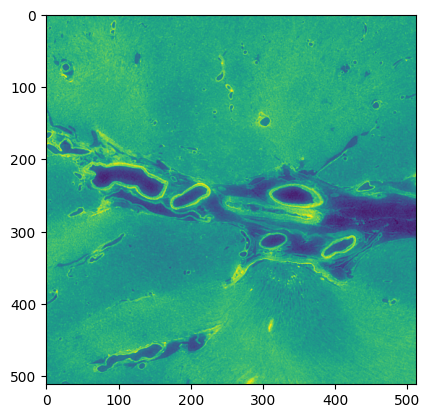

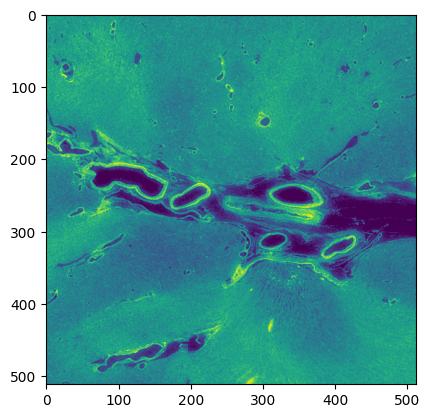

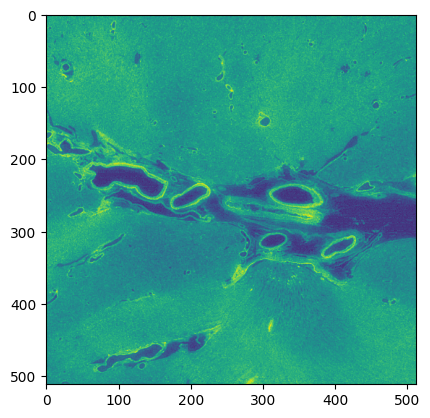

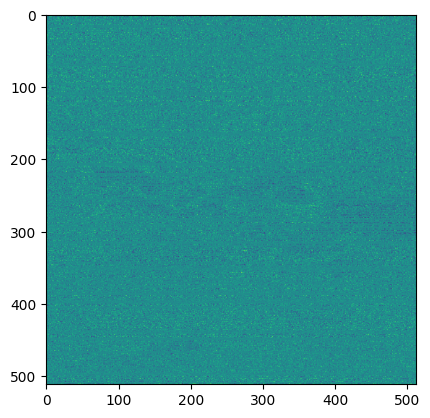

In [33]:
i = 1000
x = train_kaggled_dataset[i][0][0]
plt.imshow(x.numpy())
plt.figure()
x = norm_with_clip(x.float().reshape(-1,*x.shape[2:])).reshape(x.shape)
print(x.max(), x.min())
plt.imshow(x.numpy())
plt.figure()
x_noise = add_noise(x,max_randn_rate=0.5,x_already_normed=True)
plt.imshow(x_noise.numpy())
plt.figure()
plt.imshow((x - x_noise).numpy())


# Training

In [ ]:
model=build_model()
model=DataParallel(model)

loss_fc=DiceLoss()
#loss_fn=nn.BCEWithLogitsLoss()
optimizer=tc.optim.AdamW(model.parameters(),lr=CFG.lr)
scaler=tc.cuda.amp.GradScaler()
scheduler = tc.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr,
                                                steps_per_epoch=len(train_dataset), epochs=CFG.epochs+1,
                                                pct_start=0.1,)
for epoch in range(CFG.epochs):
    model.train()
    time=tqdm(range(len(train_dataset)))
    losss=0
    scores=0
    for i,(x,y) in enumerate(train_dataset):
        x=x.cuda().to(tc.float32)
        y=y.cuda().to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        x=add_noise(x,max_randn_rate=0.5,x_already_normed=True)
        
        with autocast():
            pred=model(x)
            loss=loss_fc(pred,y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()
        score=dice_coef(pred.detach(),y)
        losss=(losss*i+loss.item())/(i+1)
        scores=(scores*i+score)/(i+1)
        time.set_description(f"epoch:{epoch},loss:{losss:.4f},score:{scores:.4f},lr{optimizer.param_groups[0]['lr']:.4e}")
        time.update()
        del loss,pred
    time.close()
    
    model.eval()
    time=tqdm(range(len(val_dataset)))
    val_losss=0
    val_scores=0
    for i,(x,y) in enumerate(val_dataset):
        x=x.cuda().to(tc.float32)
        y=y.cuda().to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)

        with autocast():
            with tc.no_grad():
                pred=model(x)
                loss=loss_fc(pred,y)
        score=dice_coef(pred.detach(),y)
        val_losss=(val_losss*i+loss.item())/(i+1)
        val_scores=(val_scores*i+score)/(i+1)
        time.set_description(f"val-->loss:{val_losss:.4f},score:{val_scores:.4f}")
        time.update()

    time.close()
tc.save(model.module.state_dict(),f"./{CFG.backbone}_{epoch}_loss{losss:.2f}_score{scores:.2f}_val_loss{val_losss:.2f}_val_score{val_scores:.2f}_midd_rot002.pt")

time.close()